In [36]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
from astrometry.util.fits import fits_table, merge_tables

# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
from obiwan.qa import plots

In [38]:
dat= fits_table('randoms_rank98.fits')
len(dat)

Converted unique_id from |S20 to <U20
Converted tractor_brickname from |S4 to <U4
Converted tractor_type from |S4 to <U4


7704

In [39]:
dat.get_columns()

['id',
 'ra',
 'dec',
 'x',
 'y',
 'gflux',
 'mw_transmission_g',
 'rflux',
 'mw_transmission_r',
 'zflux',
 'mw_transmission_z',
 'n',
 'rhalf',
 'e1',
 'e2',
 'unique_id',
 'psql_id',
 'psql_ra',
 'psql_dec',
 'psql_g',
 'psql_r',
 'psql_z',
 'psql_rhalf',
 'psql_n',
 'psql_ba',
 'psql_pa',
 'psql_redshift',
 'tractor_release',
 'tractor_brickid',
 'tractor_brickname',
 'tractor_objid',
 'tractor_brick_primary',
 'tractor_type',
 'tractor_ra',
 'tractor_dec',
 'tractor_ra_ivar',
 'tractor_dec_ivar',
 'tractor_bx',
 'tractor_by',
 'tractor_dchisq',
 'tractor_ebv',
 'tractor_mjd_min',
 'tractor_mjd_max',
 'tractor_flux_u',
 'tractor_flux_g',
 'tractor_flux_r',
 'tractor_flux_i',
 'tractor_flux_z',
 'tractor_flux_y',
 'tractor_flux_ivar_u',
 'tractor_flux_ivar_g',
 'tractor_flux_ivar_r',
 'tractor_flux_ivar_i',
 'tractor_flux_ivar_z',
 'tractor_flux_ivar_y',
 'tractor_mw_transmission_u',
 'tractor_mw_transmission_g',
 'tractor_mw_transmission_r',
 'tractor_mw_transmission_i',
 'tractor_

(-0.0001, 0.0001)

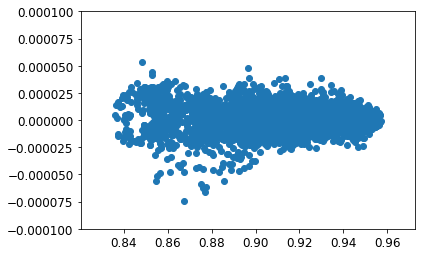

In [40]:
i= dat.obiwan_mask == 1
plt.scatter(dat.mw_transmission_g[i],
            dat.mw_transmission_g[i] - dat.tractor_mw_transmission_g[i])
plt.ylim(-1e-4,1e-4)

(-1.2, 1.2)

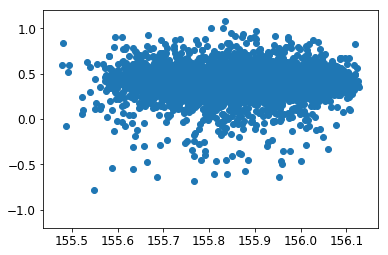

In [52]:
i= dat.obiwan_mask == 1
plt.scatter(dat.ra[i],
            (dat.ra[i] - dat.tractor_ra[i])*3600)
plt.ylim(-1.2,1.2)

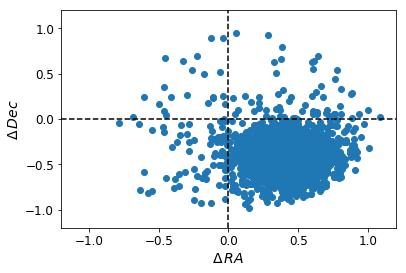

In [62]:
i= dat.obiwan_mask == 1
plt.scatter((dat.ra[i] - dat.tractor_ra[i])*3600,
            (dat.dec[i] - dat.tractor_dec[i])*3600)
plt.axhline(0,c='k',ls='--')
plt.axvline(0,c='k',ls='--')
plt.ylim(-1.2,1.2)
plt.xlim(-1.2,1.2)
plt.xlabel(r'$\Delta \, RA$')
plt.ylabel(r'$\Delta \, Dec$')

### psfsize --> rhalf

In [139]:
# recovered
isRec= dat.obiwan_mask == 1
# Types
tractor_type= np.char.strip(dat.tractor_type)
TYPES= list(set(tractor_type))
isType={}
for typ in TYPES:
    isType[typ]= tractor_type == typ
print(isType.keys())
# rhalf ~ fwhm/2
fwhm_or_rhalf= np.zeros(len(dat))+np.nan
for typ in TYPES:
    if typ in ['','COMP']:
        continue
    i= (isType[typ]) & (isRec)
    if typ == 'PSF':
        fwhm_or_rhalf[i]= np.mean([dat.get('tractor_psfsize_'+band)[i]
                                   for band in 'grz'],axis=0) / 2
    elif typ == 'SIMP':
        fwhm_or_rhalf[i]= 0.5
    elif type == 'EXP':
        fwhm_or_rhalf[i]= dat.tractor_shapeexp_r[i]
    elif type == 'DEV':
        fwhm_or_rhalf[i]= dat.tractor_shapedev_r[i]

dict_keys(['', 'DEV', 'PSF', 'COMP', 'EXP', 'SIMP'])


In [141]:
e1= np.zeros(len(dat))+np.nan
e2=e1.copy()
for typ in ['SIMP','EXP','DEV']:
    i= (isType[typ]) & (isRec)
    if typ in ['SIMP','EXP','REX']:
        e1[i]= dat.tractor_shapeexp_e1[i]
        e2[i]= dat.tractor_shapeexp_e2[i]
    elif typ in ['DEV']:
        e1[i]= dat.tractor_shapedev_e1[i]
        e2[i]= dat.tractor_shapedev_e2[i]

## Delta plots

In [160]:
diff={}

for key in ['ra','dec']:
    diff['delta_'+key]= dat.get('tractor_'+key)[isRec] - dat.get(key)[isRec] 
for key in 'xy':
    diff['delta_'+key]= dat.get('tractor_b'+key)[isRec] - dat.get(key)[isRec]
# More complicated quantities
diff['avg_num_std']= np.mean([(dat.get('tractor_flux_'+band)[isRec] - dat.get(band+'flux')[isRec])*\
                                np.sqrt(dat.get('tractor_flux_ivar_'+band)[isRec])
                              for band in 'grz'],axis=0)
assert(len(diff['avg_num_std']) == len(dat[isRec]))
#for band in 'grz':
#    diff['num_stddev_'+band]= (dat.get('tractor_flux_'+band)[isRec] - dat.get(band+'flux')[isRec])*\
#                               np.sqrt(dat.get('tractor_flux_ivar_'+band)[isRec])

diff['delta_rhalf']= fwhm_or_rhalf[isRec] - dat.rhalf[isRec]
diff['delta_e1']= e1[isRec] - dat.e1[isRec]
diff['delta_e2']= e2[isRec] - dat.e1[isRec]
# Scale
for key in ['ra','dec']:
    diff['delta_'+key]*= 3600 # arcsec
# Add Hue
diff['typ']= tractor_type[isRec]

diff= pd.DataFrame(diff)

In [161]:
diff.columns

Index(['avg_num_std', 'delta_dec', 'delta_e1', 'delta_e2', 'delta_ra',
       'delta_rhalf', 'delta_x', 'delta_y', 'typ'],
      dtype='object')

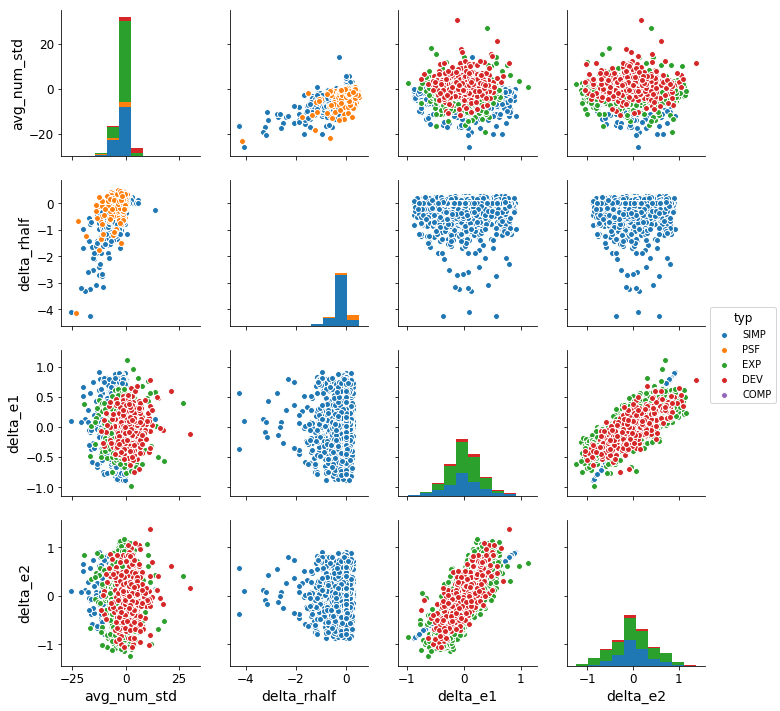

In [163]:
cols=['avg_num_std','delta_rhalf','typ','delta_e1','delta_e2']
sns.pairplot(diff[cols], hue="typ")

## Compare to straigth truth and measured quanities

In [170]:
d={}

for key in ['ra','dec']:
    d[key]= dat.get(key)[isRec] 
for key in 'xy':
    d[key]= dat.get(key)[isRec]
# More complicated quantities
d['avg_num_std']= np.mean([(dat.get('tractor_flux_'+band)[isRec] - dat.get(band+'flux')[isRec])*\
                             np.sqrt(dat.get('tractor_flux_ivar_'+band)[isRec])
                            for band in 'grz'],axis=0)
assert(len(d['avg_num_std']) == len(dat[isRec]))
#for band in 'grz':
#    diff['num_stddev_'+band]= (dat.get('tractor_flux_'+band)[isRec] - dat.get(band+'flux')[isRec])*\
#                               np.sqrt(dat.get('tractor_flux_ivar_'+band)[isRec])

d['rhalf']= dat.rhalf[isRec]
d['e1']= dat.e1[isRec]
d['e2']= dat.e1[isRec]
# Scale
for key in ['ra','dec']:
    d[key]*= 3600 # arcsec
# Add Hue
d['typ']= tractor_type[isRec]

d= pd.DataFrame(d)

In [171]:
d.columns

Index(['avg_num_std', 'dec', 'e1', 'e2', 'ra', 'rhalf', 'typ', 'x', 'y'], dtype='object')

In [172]:
cols=['avg_num_std','rhalf','typ','e1','e2']
sns.pairplot(d[cols], hue="typ")

ValueError: Big-endian buffer not supported on little-endian compiler

### delta Flux/err_estim vs. mag, with q25,50,75 lines

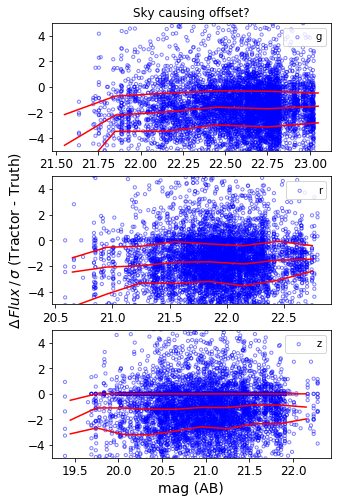

In [70]:
i= dat.obiwan_mask == 1
#truth= plots.flux2mag(dat.gflux[i]/dat.mw_transmission_g[i])
#meas= plots.flux2mag(dat.tractor_flux_g[i]/dat.tractor_mw_transmission_g[i])

fig,ax= plt.subplots(3,1,figsize=(5,8))
plt.subplots_adjust(hspace=0.2)
for iax,band in enumerate('grz'):
    x= plots.flux2mag(dat.get(band+'flux')[i]/\
                      dat.get('mw_transmission_'+band)[i])
    y= (dat.get('tractor_flux_'+band)[i] - dat.get(band+'flux')[i])*\
        np.sqrt(dat.get('tractor_flux_ivar_'+band)[i])
    ax[iax].scatter(x,y,edgecolor='b',
                    s=10,c='none',lw=1.,alpha=0.5,
                    label='%s' % band)
    binned= plots.bin_up(x,y, bin_minmax=(16,25),nbins=30)
    for perc in ['q25','q50','q75']:
        ax[iax].plot(binned['binc'],binned[perc],c='r')

for iax,band in enumerate('grz'):
    ax[iax].legend(loc='upper right')
    ax[iax].set_ylim(-5,5)
ax[1].set_ylabel(r'$\Delta\, Flux\,/\,\sigma$ (Tractor - Truth)')
ax[0].set_title('Sky causing offset?')
ax[2].set_xlabel('mag (AB)')

### delta Flux/err_estim vs. mag for a Single band 4 panels for PSF, SIMP or REX, EXP, COMP

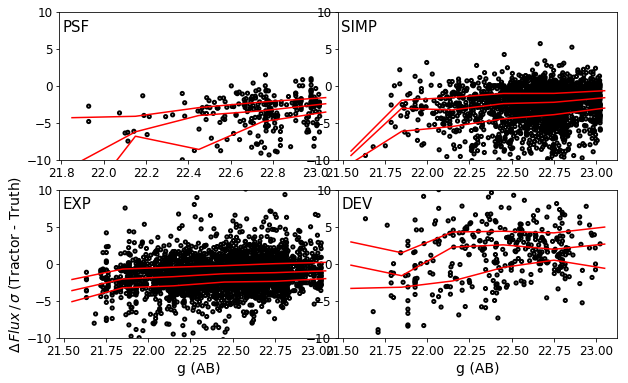

In [110]:
band='g'

isRec= dat.obiwan_mask == 1
# TYPES= 'psf simp exp dev comp rex'.split(' ')
tractor_type= np.char.strip(dat.tractor_type)
# TYPES= set(tractor_type)
# print(TYPES)
TYPES= 'psf simp exp dev'.upper().split(' ')
# print(types)
isType={}
for typ in TYPES:
    isType[typ]= tractor_type == typ
#isType=dict(typ= tractor_type == typ
#            for typ in set(tractor_type))
#truth= plots.flux2mag(dat.gflux[i]/dat.mw_transmission_g[i])
#meas= plots.flux2mag(dat.tractor_flux_g[i]/dat.tractor_mw_transmission_g[i])

fig,ax= plt.subplots(2,2,figsize=(10,6))
plt.subplots_adjust(hspace=0.2,wspace=0)
cnt=-1
for row in range(2):
    for col in range(2):
        cnt+=1
        typ= TYPES[cnt]
        i= (isRec) & (isType[typ])
        if len(dat[i]) > 0:
            x= plots.flux2mag(dat.get(band+'flux')[i]/\
                              dat.get('mw_transmission_'+band)[i])
            y= (dat.get('tractor_flux_'+band)[i] - dat.get(band+'flux')[i])*\
                np.sqrt(dat.get('tractor_flux_ivar_'+band)[i])
            ax[row,col].scatter(x,y,edgecolor='k',
                                s=10,c='none',lw=2.,alpha=1)
            binned= plots.bin_up(x,y, bin_minmax=(16,25),nbins=30)
            for perc in ['q25','q50','q75']:
                ax[row,col].plot(binned['binc'],binned[perc],c='r')
            
            plots.mytext(ax[row,col],0.01,0.9,typ,fontsize=15)
            ax[row,col].set_ylim(-10,10)

#leg=ax[0].legend(loc=(0,1.01),ncol=3,markerscale=3)
ax[1,0].set_ylabel(r'$\Delta\, Flux\,/\,\sigma$ (Tractor - Truth)')
for i in range(2):
    ax[1,i].set_xlabel('%s (AB)' % band)

### q50 filled q25-75 of delta Flux/err_estim vs. mag for each band, 1 panel per PSF, SIMP or REX, EXP, DEV

In [112]:
plt.fill_between?

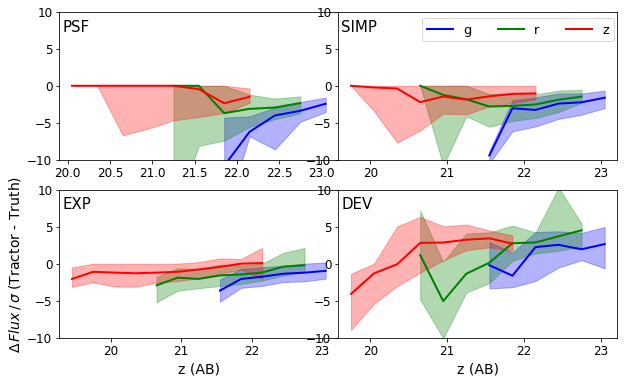

In [119]:
isRec= dat.obiwan_mask == 1
# TYPES= 'psf simp exp dev comp rex'.split(' ')
tractor_type= np.char.strip(dat.tractor_type)
# TYPES= set(tractor_type)
# print(TYPES)
TYPES= 'psf simp exp dev'.upper().split(' ')
# print(types)
isType={}
for typ in TYPES:
    isType[typ]= tractor_type == typ
#isType=dict(typ= tractor_type == typ
#            for typ in set(tractor_type))
#truth= plots.flux2mag(dat.gflux[i]/dat.mw_transmission_g[i])
#meas= plots.flux2mag(dat.tractor_flux_g[i]/dat.tractor_mw_transmission_g[i])

fig,ax= plt.subplots(2,2,figsize=(10,6))
plt.subplots_adjust(hspace=0.2,wspace=0)
cnt=-1
for row in range(2):
    for col in range(2):
        cnt+=1
        typ= TYPES[cnt]
        i= (isRec) & (isType[typ])
        if len(dat[i]) > 0:
            for band,color in zip('grz','bgr'):
                x= plots.flux2mag(dat.get(band+'flux')[i]/\
                                  dat.get('mw_transmission_'+band)[i])
                y= (dat.get('tractor_flux_'+band)[i] - dat.get(band+'flux')[i])*\
                    np.sqrt(dat.get('tractor_flux_ivar_'+band)[i])
    #             ax[row,col].scatter(x,y,edgecolor='k',
    #                                 s=10,c='none',lw=2.,alpha=1)
                binned= plots.bin_up(x,y, bin_minmax=(16,25),nbins=30)
                ax[row,col].plot(binned['binc'],binned['q50'],c=color,
                                 lw=2,label=band)
                ax[row,col].fill_between(binned['binc'],
                                         binned['q25'],binned['q75'],
                                         color=color,alpha=0.3)

            plots.mytext(ax[row,col],0.01,0.9,typ,fontsize=15)
            ax[row,col].set_ylim(-10,10)

leg=ax[0,1].legend(loc=(0.3,0.8),ncol=3,fontsize=13)
ax[1,0].set_ylabel(r'$\Delta\, Flux\,/\,\sigma$ (Tractor - Truth)')
for i in range(2):
    ax[1,i].set_xlabel('%s (AB)' % band)

### delta Flux/err_estim vs. mag but ADD for all three bands, so if tractor wrong by 2 std dev in all bands would have a +6 on the plot, one panel for each PSF, SIMP or REX, EXP, COMP

### have to choose band to plot mag of on the xaxis

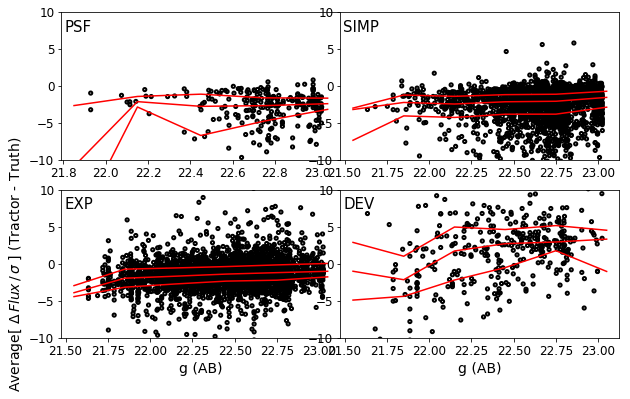

In [126]:
xaxis_band='g'

isRec= dat.obiwan_mask == 1
# TYPES= 'psf simp exp dev comp rex'.split(' ')
tractor_type= np.char.strip(dat.tractor_type)
# TYPES= set(tractor_type)
# print(TYPES)
TYPES= 'psf simp exp dev'.upper().split(' ')
# print(types)
isType={}
for typ in TYPES:
    isType[typ]= tractor_type == typ
#isType=dict(typ= tractor_type == typ
#            for typ in set(tractor_type))
#truth= plots.flux2mag(dat.gflux[i]/dat.mw_transmission_g[i])
#meas= plots.flux2mag(dat.tractor_flux_g[i]/dat.tractor_mw_transmission_g[i])

fig,ax= plt.subplots(2,2,figsize=(10,6))
plt.subplots_adjust(hspace=0.2,wspace=0)
cnt=-1
for row in range(2):
    for col in range(2):
        cnt+=1
        typ= TYPES[cnt]
        i= (isRec) & (isType[typ])
        if len(dat[i]) > 0:
            x= plots.flux2mag(dat.get(xaxis_band+'flux')[i]/\
                                      dat.get('mw_transmission_'+xaxis_band)[i])
            y= np.mean([(dat.get('tractor_flux_'+band)[i] - dat.get(band+'flux')[i])*\
                         np.sqrt(dat.get('tractor_flux_ivar_'+band)[i])
                        for band in 'grz'],axis=0)
            assert(len(y) == len(dat[i]))
            ax[row,col].scatter(x,y,edgecolor='k',
                                s=10,c='none',lw=2.,alpha=1)
            binned= plots.bin_up(x,y, bin_minmax=(16,25),nbins=30)
            for perc in ['q25','q50','q75']:
                ax[row,col].plot(binned['binc'],binned[perc],c='r')
            
            plots.mytext(ax[row,col],0.01,0.9,typ,fontsize=15)
            ax[row,col].set_ylim(-10,10)

#leg=ax[0].legend(loc=(0,1.01),ncol=3,markerscale=3)
ax[1,0].set_ylabel(r'Average[ $\Delta\, Flux\,/\,\sigma$ ] (Tractor - Truth)')
for i in range(2):
    ax[1,i].set_xlabel('%s (AB)' % xaxis_band)

### Ditto above except draw median lines for all TYPES on same panel, and different panel for xaxis_band  in grz

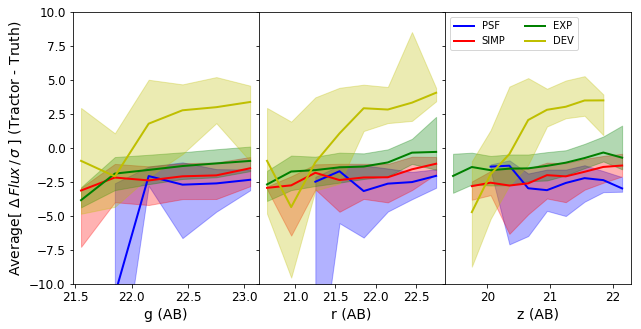

In [132]:
isRec= dat.obiwan_mask == 1
# TYPES= 'psf simp exp dev comp rex'.split(' ')
tractor_type= np.char.strip(dat.tractor_type)
# TYPES= set(tractor_type)
# print(TYPES)
TYPES= 'psf simp exp dev'.upper().split(' ')
# print(types)
isType={}
for typ in TYPES:
    isType[typ]= tractor_type == typ
#isType=dict(typ= tractor_type == typ
#            for typ in set(tractor_type))
#truth= plots.flux2mag(dat.gflux[i]/dat.mw_transmission_g[i])
#meas= plots.flux2mag(dat.tractor_flux_g[i]/dat.tractor_mw_transmission_g[i])

fig,axes= plt.subplots(1,3,figsize=(10,5))
plt.subplots_adjust(wspace=0)
cnt=-1
for ax,xaxis_band in zip(axes,'grz'):
    for typ,color in zip(TYPES,'brgy'):
        i= (isRec) & (isType[typ])
        if len(dat[i]) > 0:
            x= plots.flux2mag(dat.get(xaxis_band+'flux')[i]/\
                                      dat.get('mw_transmission_'+xaxis_band)[i])
            y= np.mean([(dat.get('tractor_flux_'+band)[i] - dat.get(band+'flux')[i])*\
                         np.sqrt(dat.get('tractor_flux_ivar_'+band)[i])
                        for band in 'grz'],axis=0)
            assert(len(y) == len(dat[i]))
            
            binned= plots.bin_up(x,y, bin_minmax=(16,25),nbins=30)
            ax.plot(binned['binc'],binned['q50'],c=color,
                    lw=2,label=typ)
            ax.fill_between(binned['binc'],
                            binned['q25'],binned['q75'],
                            color=color,alpha=0.3)
            
    #plots.mytext(ax,0.01,0.9,typ,fontsize=15)
    ax.set_ylim(-10,10)
    ax.set_xlabel('%s (AB)' % xaxis_band)

leg=axes[-1].legend(loc='upper left',ncol=2)
axes[0].set_ylabel(r'Average[ $\Delta\, Flux\,/\,\sigma$ ] (Tractor - Truth)')
for i in [1,2]:
    axes[i].set_yticklabels([])

In [121]:
np.mean([np.arange(10) for i in range(3)],axis=0)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])